In [2]:
%matplotlib widget

In [6]:
import os
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from common import metadata

# choose session 7
root = '/Users/lukearend/phd/kfx/data'
file = '2022-08-11-01-55-00_M018_SAL_mPFC_HPC_0_0_0mpk_g0_t0.imec1.lf.bin'
path = os.path.join(root, file)
md = metadata.loc[(7, 'lfp', 'hpc')]

In [12]:
# establish memory map to data
nchans = md.nchans
nsamples = md.sizebytes // nchans // 2
chanstart = md.chanstart
chanend = md.chanend + 1
memmap = np.memmap(path, dtype='int16', mode='r', shape=(nchans, nsamples), offset=0, order='F')
lfp = memmap[chanstart:chanend, :]
sy = memmap[md.chansys, :]

In [24]:
# read in a time block of data
offset_secs = 0
block_secs = 60
offset = int(offset_secs * md.samplerate)
nsamples = int(block_secs * md.samplerate)
int2microV = md.maxvolts / md.bitdepth / md.gain * 1e6
X = np.array(lfp[:, offset:offset + nsamples]).T * int2microV # convert to microV
X = X - np.median(X, axis=0) # remove DC offset
X = (X[:, ::2] + X[:, 1::2]) / 2 # average pairs at same depth
X = X - np.median(X, axis=1, keepdims=True) # rereference to common average

interactive(children=(FloatSlider(value=0.0, description='offset (s)', max=49.0, step=1.0), FloatLogSlider(val…

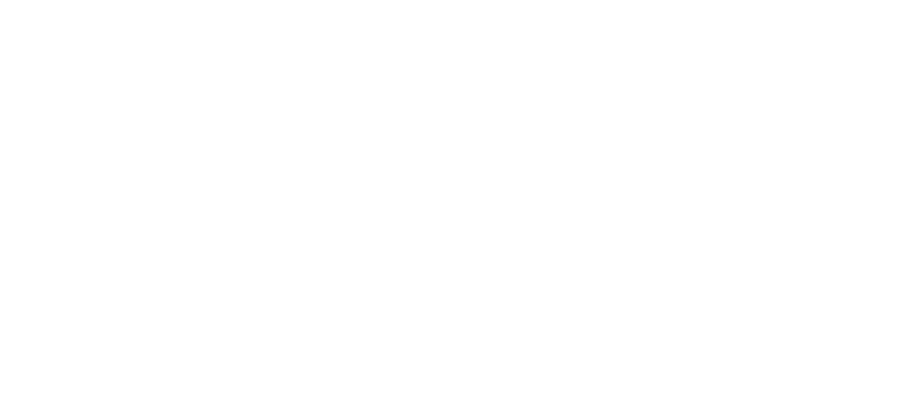

In [27]:
# plot voltage as a function of depth and time
window = widgets.FloatLogSlider(
    description='window (s)',
    value=0, min=-2, max=1, base=10, step=0.1,
)
start = widgets.FloatSlider(
    description='offset (s)',
    value=0, max=49, step=1,
)

fig = plt.figure(figsize=(9, 4))
@widgets.interact(window=window, start=start)
def fn(start, window):
    start = int(start * md.samplerate)
    window = int(window * md.samplerate)
    fig.imshow(X[start:start+window, :].T, aspect='auto', cmap='viridis')
    fig.show()